In [598]:
import numpy, pandas, glob, random, seaborn, re, matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from matplotlib.lines import Line2D
from matplotlib import colors
import sklearn.linear_model
from sklearn.model_selection import KFold
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest
from pyplink import PyPlink
import rpy2.robjects as R
from Bio import Entrez
matplotlib.rcParams['figure.dpi'] = 300

In [600]:
# define cohort and taxonomy level
cohort = 'both'
taxa_level = 'genus'
bmi_or_not = 'bmi'
classification = 'silva'
classification_method = classification + '_classification'
Entrez.email = "cdiener@isbscience.org"

In [669]:
def rename_numerical_id(ID):
    if re.match("^[0-9]", str(ID)) != None:
        return 'X' + str(ID)
    else:
        return str(ID)
    
def gxe_analysis(non_gxe_formula, gxe_formula, df):
    reg_fit = ols(non_gxe_formula, df).fit()
    gxe_fit = ols(gxe_formula, df).fit()
    anova_pval = anova_lm(reg_fit, gxe_fit).loc[1,'Pr(>F)']
    return reg_fit.rsquared, gxe_fit.rsquared, gxe_fit.params['gxe'], anova_pval

def run_gxe(rsid, metab, microbe, genotype, geno_pheno_covar):
    temp_geno = pandas.DataFrame([])
    temp_snp_df = pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid])
    temp_geno = temp_geno.join(temp_snp_df, how='outer')

    temp_geno_pheno_covar = pheno_covar_merged[[metab, microbe] + covariates].join(temp_geno, how = 'inner').dropna()
    temp_geno_pheno_covar['gxe'] = temp_geno_pheno_covar[rsid] * temp_geno_pheno_covar[microbe]

    reg_formula = metab + ' ~ ' + ' + '.join(q_covar + rename_c_covar + [rsid, microbe])
    gxe_formula = metab + ' ~ ' + ' + '.join(q_covar + rename_c_covar + [rsid, microbe, 'gxe'])

    reg_r_sq, gxe_r_sq, gxe_beta, gxe_pval = gxe_analysis(reg_formula, gxe_formula, temp_geno_pheno_covar)
    
def rsid2gene(ids):
    """Find the genes for a set of rsids."""
    id_str = ",".join([idx.replace("rs", "") for idx in ids])
    post = Entrez.read(Entrez.epost(db="snp", id=id_str))
    summaries = Entrez.read(Entrez.esummary(
        db="snp", 
        query_key=post["QueryKey"], 
        webenv=post["WebEnv"], 
        retmax=10000
    ))
    genes = []
    for s in summaries["DocumentSummarySet"]["DocumentSummary"]:
        if "GENES" in s and len(s["GENES"]) > 0:
            genes.append({
                "snp": "rs" + s["SNP_ID"],
                "genes": ",".join(g["NAME"] for g in s["GENES"]),
                "clinical": s["CLINICAL_SIGNIFICANCE"],
                "chromosome": s["CHR"],
                "function_class": s["FXN_CLASS"]
            })
        else:
            genes.append(dict())
    return pd.DataFrame.from_records(genes)


/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# load phenotype 

In [320]:
# load pheno
micro_metab_unadj = pandas.read_csv('./joint_pheno/{0}_{1}_{2}_micro_metab_unadj.pheno'.format(cohort, taxa_level, classification), index_col = [0,1])
micro_metab_covar = pandas.read_csv('./joint_pheno/{0}_{1}_{2}_micro_metab_unadj.covar'.format(cohort, taxa_level, classification), index_col = [0,1])
pheno_covar_merged_full = micro_metab_unadj.join(micro_metab_covar)
pheno_covar_merged_full.index = pheno_covar_merged_full.index.droplevel(0)
pheno_covar_merged_full.columns = [rename_numerical_id(col) for col in pheno_covar_merged_full.columns]

# define covariates
q_covar = ['age','age_sq','sex_age','sex_age_sq','PC1','PC2','PC3','PC4','PC5', 'bmi']
c_covar = ['sex','batch']
rename_c_covar = ['C({0})'.format(covar) for covar in c_covar]
covariates = q_covar + c_covar

form_covar = ['scale(age)', 'I(scale(age)**2)', 'PC1','PC2','PC3','PC4','PC5', 'bmi']
int_covar = ['scale(age)*C(sex)', 'I(scale(age)**2)*C(sex)']
form_covar = form_covar + rename_c_covar + int_covar

# load association
micro_metab_assoc = pandas.read_csv('./assoc_results/{0}_sig_metab_{1}_{2}_classification_lasso.csv'.format(cohort, taxa_level, classification))
micro_metab_assoc['metabolite_id'] = [rename_numerical_id(identifier) for identifier in micro_metab_assoc['metabolite_id']]
micro_metab_assoc['tax_id'] = [rename_numerical_id(identifier) for identifier in micro_metab_assoc['tax_id']]
sig_metabolite = micro_metab_assoc['metabolite_id'].unique()
print(len(sig_metabolite))

# get metadata
metabolite_metadata = pandas.read_csv('./input_pheno/all_metab_11192021.pheno.metadata', sep = '\t', dtype=str)
metabolite_metadata = metabolite_metadata.groupby('metabolite_id').first()[['metabolite', 'sub_pathway', 'super_pathway']]
metabolite_metadata.index = [rename_numerical_id(identifier) for identifier in metabolite_metadata.index]
metabolite_metadata_dict = metabolite_metadata['metabolite'].to_dict()
metabolite_super_pathway_dict = metabolite_metadata['super_pathway'].to_dict()

taxa_metadata = pandas.read_csv('./joint_pheno/{0}_{1}.metadata'.format(taxa_level, classification_method), dtype=str, sep = '\t')
taxa_metadata = taxa_metadata.set_index('tax_id')
taxa_metadata.index = [rename_numerical_id(identifier) for identifier in taxa_metadata.index]
genus_metadata_dict = taxa_metadata['taxonomy'].str.split(';').str.get(-1).to_dict()

176


# get genotype

In [321]:
genotype = PyPlink('./input_bed/all_chr/all_genomes_09112019_all_chr')
# genotype = PyPlink('/homedir/notebooks-cheng/mgwas/data/snp_query_03182019/final_merged/bed_files/all_chr/merged_metabolome_inds_biallelic_variants_all_chr')
sample_ids = genotype.get_fam().iid.values

In [322]:
snp_list = 'validate_gwas/clumped_variants/metab/fastgwa/clumped_10perc_second_pass_list.txt'
sig_metab_assoc = pandas.read_csv(snp_list, sep = '\t', header = None)
sig_metab_assoc.columns = ['rsid', 'Phenotype']

# subset to phenotypes that have microbiome associations
sig_metab_assoc = sig_metab_assoc[sig_metab_assoc['Phenotype'].isin(micro_metab_assoc['metabolite_id'].values)]
sig_metab_assoc = sig_metab_assoc[~sig_metab_assoc['Phenotype'].str.contains('X99')]
print(len(sig_metab_assoc['Phenotype'].unique()))

176


# run GxE

In [323]:
from multiprocessing import Pool
from rich.progress import track
from itertools import product

pheno_covar_merged = pheno_covar_merged_full.copy()

gxe_results = []
rev_rsid_map = {}
microbes = list(micro_metab_assoc['tax_id'].unique())

# Assemble a table of all SNPs
metabs = list(sig_metab_assoc['Phenotype'].unique())
rsids = sig_metab_assoc['rsid'].unique()
renamed_rsids = pandas.Series({i: i.split(';')[0] for i in rsids})
dfs = [pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid]) for rsid in rsids]
geno = pandas.concat(dfs, axis=1)
geno.rename(columns = renamed_rsids, inplace=True)
geno_pheno_covar = pheno_covar_merged[metabs + microbes + covariates].join(geno, how = 'outer')

def betas(args):
    """Get the gene environment interaction coefficients."""
    metab, microbe = args
    rsids = renamed_rsids[sig_metab_assoc.loc[sig_metab_assoc['Phenotype'] == metab, 'rsid']].tolist()
    # print(metab, metabolite_metadata_dict[metab], f'# snps: {len(rsids)}', f'# bugs: {len(microbes)}')

    df = geno_pheno_covar[[metab] + [microbe] + rsids + covariates].dropna()

    gxes = []
    
    result = pandas.DataFrame(
        index = [metab + ':' + microbe + ':' + i for i in rsids],
        columns = ['metabolite_id','tax_id','rsid', 'genetics_beta', 'gxe_beta','pval', 
                   'baseline_rsq', 'without_microbe_rsq', 'gxe_rsq', 'n_alt_0', 'n_alt_1', 'n_alt_2']
    )
    for rsid in rsids:

        try:
            assert (df.groupby(rsid).count() > 30).all().all()
            n_alt_count = df.groupby(rsid).count()
            n_alt_0 = n_alt_count.loc[0][0]
            n_alt_1 = n_alt_count.loc[1][0]
            n_alt_2 = n_alt_count.loc[2][0]
        except:
            continue 
        gxe_term = rsid + ':' + microbe
        no_microbe_formula = metab + ' ~ ' + ' + '.join(form_covar + [rsid])    
        no_gxe_formula = metab + ' ~ ' + ' + '.join(form_covar + [rsid] + [microbe])
        gxe_formula = metab + ' ~ ' + ' + '.join(form_covar + [rsid] + [microbe] + [gxe_term])
        
        no_int_out = ols(no_gxe_formula, df).fit()
        baseline_rsq = no_int_out.rsquared
        
        no_microbe_rsq = ols(no_microbe_formula, df).fit().rsquared
        
        int_out = ols(gxe_formula, df).fit()
        int_rsq = int_out.rsquared
        gxe_beta = int_out.params.loc[gxe_term]
        genetics_beta = int_out.params.loc[rsid]
        gxe_pval = int_out.pvalues.loc[gxe_term]
        
        result.loc[metab + ':' + microbe + ':' + rsid] = [
            metab, microbe, rsid, genetics_beta, gxe_beta, gxe_pval, baseline_rsq, no_microbe_rsq, 
            int_rsq, n_alt_0, n_alt_1, n_alt_2
        ]
            
    return result

with Pool(8) as pool:
    args = [(met, mic) for met in metabs for mic in microbes]
    it = track(pool.imap_unordered(betas, args), total=len(args), description='Fitting models')
    results = pandas.concat(list(it))

fdr_pass, adj_pval, sidack, bonff = statsmodels.stats.multitest.multipletests(results['pval'].values, method='fdr_bh', alpha=0.05)
results['pass_fdr'] = adj_pval < 0.05
results['adj_pval'] = adj_pval


Output()

In [670]:
genes = rsid2gene(gxe_fold_results_annotated.rsid.unique())

In [671]:
gxe_fold_results_df = results.copy().dropna()
gxe_fold_results_annotated = gxe_fold_results_df.merge(metabolite_metadata, left_on = 'metabolite_id', right_index = True, how = 'left')
gxe_fold_results_annotated = gxe_fold_results_annotated.merge(taxa_metadata, left_on = 'tax_id', right_index = True, how = 'left')
gxe_fold_results_annotated['genus'] = gxe_fold_results_annotated['taxonomy'].str.split(';').str.get(-1)
gxe_fold_results_annotated['family'] = gxe_fold_results_annotated['taxonomy'].str.split(';').str.get(-2)

gxe_fold_results_annotated = gxe_fold_results_annotated.merge(genes, on = 'rsid', how = 'left')

gxe_fold_results_annotated.head()

,metabolite_id,tax_id,rsid,genetics_beta,gxe_beta,pval,baseline_rsq,without_microbe_rsq,gxe_rsq,n_alt_0,...,Class,Order,Family,Genus,Species,sequence,taxonomy,genus,family,gene_symbol
0,X100000007,X82fd57626e8c0cfd95cc16b8199ba431_genus,rs1171617,0.056038,-0.003356,0.629449,0.190989,0.19079,0.191164,56,...,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminiclostridium_5,NaN,NaN,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,g__Ruminiclostridium_5,f__Ruminococcaceae,SLC16A9
1,X100000007,X57e80f5c1e5d43e276db32838721af29_genus,rs1171617,0.05623,-0.008195,0.034698,0.193234,0.192698,0.19653,56,...,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Marvinbryantia,NaN,NaN,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,g__Marvinbryantia,f__Lachnospiraceae,SLC16A9
2,X100000007,X4da432593d8dc87e0e275f1077755111_genus,rs1171617,0.055799,0.001503,0.824796,0.19407,0.193541,0.194107,54,...,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Lachnospira,NaN,NaN,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,g__Lachnospira,f__Lachnospiraceae,SLC16A9
3,X100000007,X909b8848be3595a45c5a70038116808f_genus,rs1171617,0.05633,-0.001235,0.796451,0.19455,0.192878,0.1946,56,...,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__UBA1819,NaN,NaN,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,g__UBA1819,f__Ruminococcaceae,SLC16A9
4,X100000007,X850b64752c573c8785e7997aa9daf0d6_genus,rs1171617,0.05575,0.003881,0.278454,0.192701,0.192698,0.19357,56,...,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Lachnospiraceae_ND3007_group,NaN,NaN,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,g__Lachnospiraceae_ND3007_group,f__Lachnospiraceae,SLC16A9


In [672]:
sig_gxe_fold_results_annotated = gxe_fold_results_annotated[gxe_fold_results_annotated['pass_fdr'] == True]

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [673]:
min_count = 30
gxe_results_sig_abundant = sig_gxe_fold_results_annotated[(sig_gxe_fold_results_annotated['n_alt_0'] > min_count) & 
                                           (sig_gxe_fold_results_annotated['n_alt_1'] > min_count) & 
                                           (sig_gxe_fold_results_annotated['n_alt_2'] > min_count)]

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [674]:
gxe_results_sig_abundant["gxe_only_rsq"] = gxe_results_sig_abundant.gxe_rsq - gxe_results_sig_abundant.baseline_rsq
temp_gxe_interest = gxe_results_sig_abundant.sort_values('pval', ascending=True).drop_duplicates()
temp_gxe_interest = temp_gxe_interest.reset_index(drop = True)

In [1]:
from plotnine import *
import numpy as np
from scipy.stats import pearsonr

s = sig_gxe_fold_results_annotated

s.genetics_beta = s.genetics_beta.astype("float")
s.gxe_beta = s.gxe_beta.astype("float")
s.without_microbe_rsq = s.without_microbe_rsq.astype("float")
s.gxe_rsq = s.gxe_rsq.astype("float")
s.baseline_rsq = s.baseline_rsq.astype("float")
s["neg_log_pval"] = -np.log10(s.pval.astype("float"))
s["type"] = "opposite"
s.loc[s.gxe_beta * s.genetics_beta > 0, "type"] = "same"
s["gxe_only_rsq"] = s.gxe_rsq - s.baseline_rsq
s["genetics_rsq"] = s.without_microbe_rsq

pl = (
    ggplot(s, aes(y="gxe_only_rsq", x="genetics_rsq", color="type", group=1))
    + geom_smooth(linetype="dashed", method="lm")
    + geom_point(size=2)
    + theme_minimal()
    + geom_text(aes(label="metabolite"), data=s[s.gxe_only_rsq > 0.01], ha="left", nudge_x=0.01, size=10)
    + labs(x="R² genetics", y="R² gene:microbe", color="direction")
    + scale_color_manual(values=["tomato", "royalblue"])
)
print(pearsonr(s.gxe_only_rsq, s.genetics_rsq))
pl.save("figures/genetics_vs_gxe.pdf", width=6, height=5)
pl

NameError: name 'sig_gxe_fold_results_annotated' is not defined

In [661]:
s[s.tax_id == "alpha_div"]

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,metabolite_id,tax_id,rsid,genetics_beta,gxe_beta,pval,baseline_rsq,without_microbe_rsq,gxe_rsq,n_alt_0,...,Species,sequence,taxonomy,genus,family,gene_symbol,neg_log_pval,type,gxe_only_rsq,genetics_rsq
4254,X100001856,alpha_div,rs1077835,0.105161,0.147573,0.015634,0.075429,0.071495,0.080361,653,...,NaN,NaN,Shannon alpha diversity,Shannon alpha diversity,NaN,LIPC,1.805924,same,0.004932,0.071495
4407,X100001869,alpha_div,rs174547,-0.097314,0.044702,0.018999,0.254121,0.238970,0.257885,488,...,NaN,NaN,Shannon alpha diversity,Shannon alpha diversity,NaN,FADS1,1.721276,opposite,0.003764,0.238970
6457,X100004227,alpha_div,rs62149622,-0.131579,0.177241,0.01821,0.134813,0.133252,0.139393,644,...,NaN,NaN,Shannon alpha diversity,Shannon alpha diversity,NaN,LOC105374802,1.739681,opposite,0.004580,0.133252


# plot

In [584]:
for i in temp_gxe_interest.index[0:5]:
    hit = temp_gxe_interest.loc[i]
    sig_metab = hit['metabolite_id']
    sig_rsid = hit['rsid']
    sig_microbe = hit['tax_id']
    temp_hit_geno = pandas.DataFrame(genotype.get_acgt_geno_marker(sig_rsid), index = sample_ids, columns = [sig_rsid])
    temp_hit_geno = temp_hit_geno.join(pandas.DataFrame(genotype.get_geno_marker(sig_rsid), index = sample_ids, columns = [sig_rsid + '_alt_count']))
    temp_pheno_covar_merged = pheno_covar_merged[[sig_metab, sig_microbe] + covariates].join(temp_hit_geno, how = 'inner').dropna()

    bim = genotype.get_bim()
    hit_minor_allele = bim.loc[sig_rsid, 'a1']
    hit_major_allele = bim.loc[sig_rsid, 'a2']
    allele_order = [hit_major_allele*2, hit_minor_allele + hit_major_allele, hit_minor_allele*2]

    temp_cov_adj_formula = sig_metab + ' ~ ' + ' + '.join(form_covar + rename_c_covar)
    temp_cov_adj_lm = ols(temp_cov_adj_formula, temp_pheno_covar_merged).fit()
    temp_pheno_covar_merged['covar_adj'] = temp_cov_adj_lm.resid

    print(sig_rsid, metabolite_metadata_dict[sig_metab], genus_metadata_dict[sig_microbe])

    scatter_args = {'linewidth':0.3, 'edgecolor':'black', 'color':'slategrey'}
    line_args = {'color':'slategrey'}
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (10,4), sharey= False)
    sns.boxplot(x = sig_rsid, y= 'covar_adj', data = temp_pheno_covar_merged, 
                order = allele_order, ax = ax1, palette = 'Set1', showfliers = False, showcaps = False)
    sns.stripplot(x = sig_rsid, y= 'covar_adj', data = temp_pheno_covar_merged, 
                  order = allele_order, ax = ax1, palette = 'Set1', linewidth=0.5, alpha = 0.5)
    sns.regplot(x = sig_microbe, y = 'covar_adj', data = temp_pheno_covar_merged,
                scatter_kws = scatter_args, ax = ax2,
               line_kws = line_args)
    ax1.set_ylabel(metabolite_metadata_dict[sig_metab])
    ax2.set_ylabel('')
    ax2.set_xlabel(genus_metadata_dict[sig_microbe])
    sns.despine()
    plt.savefig(f"figures/{sig_metab}|{sig_microbe}|{sig_rsid}_basic.png", dpi=300, width=6, height=4, bbox_inches="tight")
    plt.show()
    plt.close()
    
    print(scipy.stats.pearsonr(temp_pheno_covar_merged['covar_adj'], temp_pheno_covar_merged[sig_microbe])[0])
    for index, (protein_genotype, subset_df) in enumerate(temp_pheno_covar_merged.groupby(sig_rsid)):
        slope, intercept, r, pval, std = scipy.stats.linregress(subset_df['covar_adj'], subset_df[sig_microbe])
        print(protein_genotype, r, pval)
    
    g = sns.FacetGrid(data=temp_pheno_covar_merged, col=sig_rsid, col_order = allele_order)
    g.map(sns.regplot, sig_microbe, sig_metab,  scatter_kws = scatter_args, line_kws = line_args)
    g.set(xlim=(temp_pheno_covar_merged[sig_microbe].min()*1.1, temp_pheno_covar_merged[sig_microbe].max()*1.1),
         ylim=(temp_pheno_covar_merged[sig_metab].min()*1.1, temp_pheno_covar_merged[sig_metab].max()*1.1))
    g.set_xlabels(genus_metadata_dict[sig_microbe])
    g.set_ylabels(metabolite_metadata_dict[sig_metab])
    plt.savefig(f"figures/{sig_metab}|{sig_microbe}|{sig_rsid}_groups.png", dpi=300, width=6, height=4, bbox_inches="tight")
    plt.show()
    plt.close()

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0.09204163703344605
0.14357944055753052


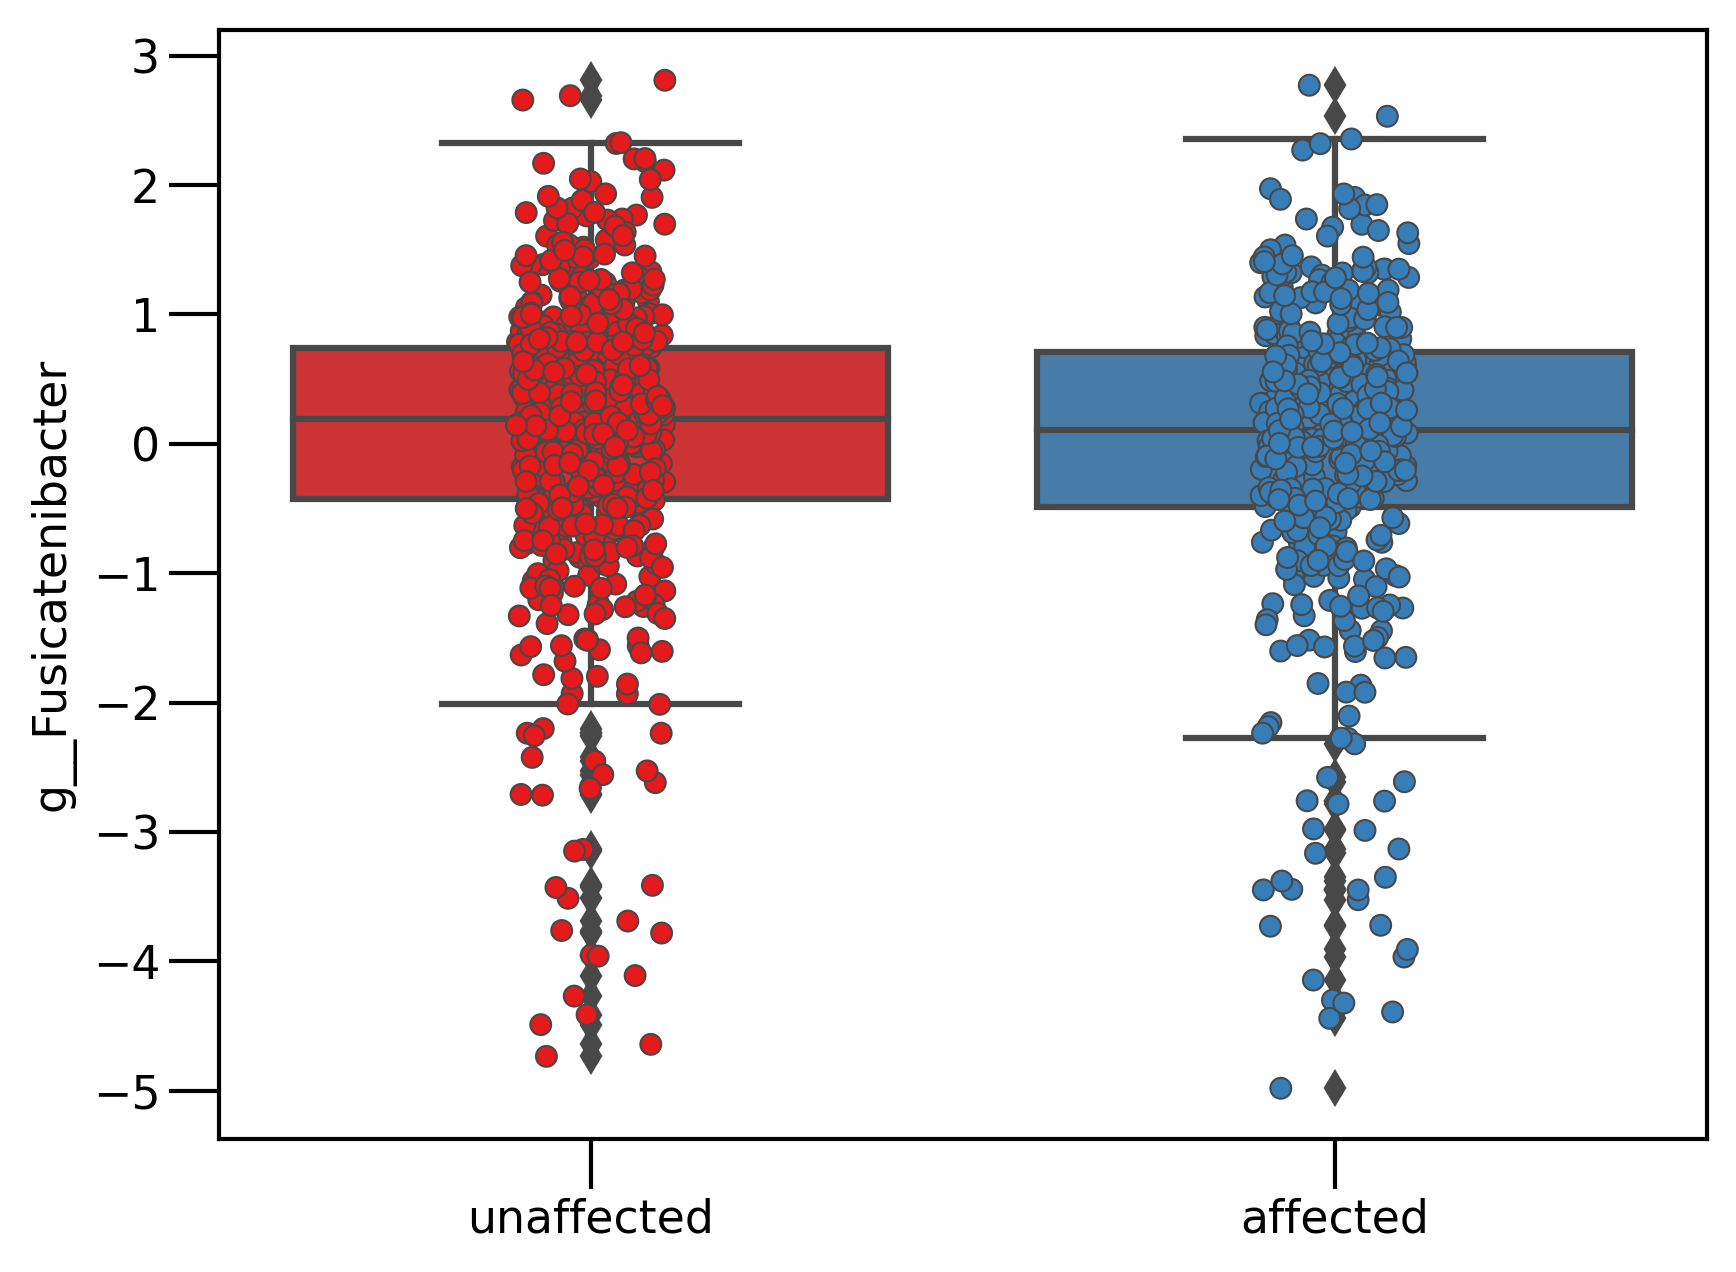

In [332]:
temp_pheno_covar_merged['affected'] = [1 if i.count(hit_minor_allele) > 0 
                                       else 0 
                                       for i in temp_pheno_covar_merged[sig_rsid]]
affected_order = [0, 1]
affected_x_tick_label = list(map({0:'unaffected', 1:'affected'}.get, affected_order))

print(ols('{0} ~ {1}'.format(sig_microbe,'affected'), data=temp_pheno_covar_merged).fit().pvalues['affected'])
print(ols('{0} ~ {1}'.format(sig_microbe,sig_rsid+'_alt_count'), data=temp_pheno_covar_merged).fit().pvalues[sig_rsid+'_alt_count'])


fig, ax = plt.subplots()
sns.boxplot(x = 'affected', y= sig_microbe, data = temp_pheno_covar_merged, order = [0, 1], ax = ax, palette = 'Set1')
sns.stripplot(x = 'affected', y= sig_microbe, data = temp_pheno_covar_merged, order = [0, 1], ax = ax, palette = 'Set1', linewidth=0.5)
ax.set_xticklabels(affected_x_tick_label)
ax.set_xlabel('')
ax.set_ylabel(genus_metadata_dict[sig_microbe])
plt.show()
plt.close()

In [662]:
gxe_fold_results_annotated.shape

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(16905, 29)

In [663]:
(temp_gxe_interest.gxe_rsq - temp_gxe_interest.baseline_rsq).astype(float).describe()

count    196.000000
mean       0.005113
std        0.001364
min        0.002232
25%        0.004305
50%        0.004729
75%        0.005651
max        0.010500
dtype: float64

In [676]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def stars(p):
    if p>0.05:
        return "n.s."
    else:
        return sum(p < c for c in [0.05, 0.01, 0.001]) * "٭"

def enrichment(full_data, sig_data, column, figsize=(3, 4), min_sig=1):
    full_counts = full_data[column].value_counts()
    sig_counts = sig_data[column].value_counts()
    stats = pd.DataFrame({"full_counts": full_counts, "sig_counts": sig_counts, "n": full_counts.sum(), "sig_n": sig_counts.sum()}).fillna(0)
    stats["p"] = stats.apply(lambda df: hypergeom.sf(max(0, df.sig_counts - 1), df.n, max(df.full_counts, 1), df.sig_n), axis=1)
    stats["odds"] = (stats.sig_counts / stats.sig_n) / (stats.full_counts / stats.n)
    stats["log_odds"] = np.log(stats.odds)
    stats["q"] = multipletests(stats.p, method="fdr_bh")[1]
    
    stats["all"] = stats["full_counts"] / stats["n"]
    stats["significant"] = stats["sig_counts"] / stats["sig_n"]
    stats.index.name = column
    stats.reset_index(inplace=True)
    
    long = stats[stats.sig_counts >= min_sig].melt(id_vars=[column, "p", "q"], value_vars=["all", "significant"], value_name="prevalence", var_name="group")
    long[column] = pd.Categorical(long[column], long.sort_values(by="prevalence")[column].unique()) 
    long["sig_stars"] = long.q.apply(stars)
    
    pl = (
        ggplot(long, aes(x="prevalence", y=column, shape="group", color="group")) +
        geom_line(aes(group=column), color="black") +
        geom_point(size=2) +
        theme_minimal() +
        theme(figure_size=figsize) +
        labs(y="")
    )
    if (long.q < 0.05).any():
        pl += geom_text(
            aes(label="sig_stars"), 
            data=long[(long.q<0.05) & (long.group == "significant")], 
            color="black", va="center", ha="left", 
            nudge_x=(long.prevalence.max() - long.prevalence.min())*0.025)
    
    return stats.sort_values(by="p"), pl

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [694]:
pathway_enr = enrichment(gxe_fold_results_annotated, sig_gxe_fold_results_annotated, "sub_pathway", figsize=(3, 5))
microbe_enr = enrichment(gxe_fold_results_annotated, sig_gxe_fold_results_annotated, "family", figsize=(3, 4))
gene_enr = enrichment(gxe_fold_results_annotated, sig_gxe_fold_results_annotated, "gene_symbol", figsize=(3, 7))

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log


/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 5 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/enriched_pathways.pdf
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated i

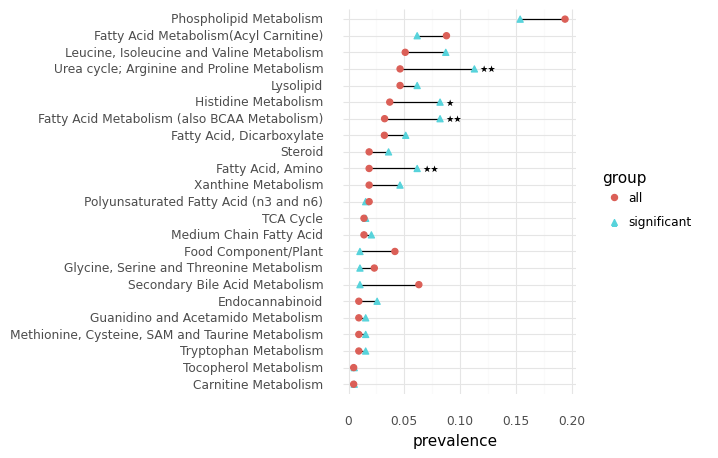

<ggplot: (8745807336951)>

In [700]:
pathway_enr[1].save("figures/enriched_pathways.pdf", width=3, height=5)
pathway_enr[1]

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 4 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/enriched_microbes.pdf
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated i

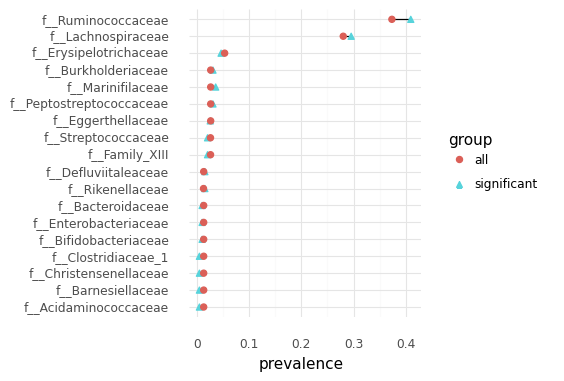

<ggplot: (8745800405474)>

In [701]:
microbe_enr[1].save("figures/enriched_microbes.pdf", width=3, height=4)
microbe_enr[1]

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 7 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/enriched_genes.pdf
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in N

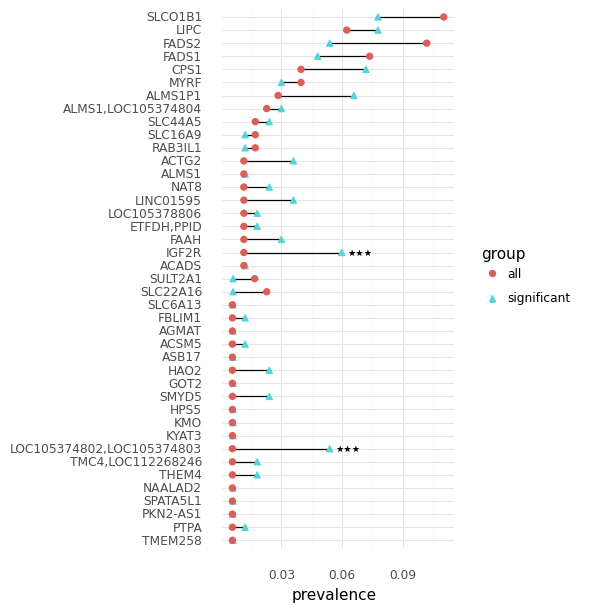

<ggplot: (8746134735523)>

In [702]:
gene_enr[1].save("figures/enriched_genes.pdf", width=3, height=7)
gene_enr[1]

In [417]:
snp_enr[0]

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,rsid,full_counts,sig_counts,n,sig_n,p,odds,log_odds,q,all,significant
112,rs62149622,76,9.0,16905,196,2.296497e-07,10.213816,2.323741,0.000032,0.004496,0.045918
139,rs998075,76,7.0,16905,196,2.813623e-05,7.944079,2.072427,0.001313,0.004496,0.035714
68,rs2258844,76,7.0,16905,196,2.813623e-05,7.944079,2.072427,0.001313,0.004496,0.035714
77,rs296381,76,5.0,16905,196,1.889463e-03,5.674342,1.735955,0.055716,0.004496,0.025510
48,rs174547,152,7.0,16905,196,1.989840e-03,3.972039,1.379280,0.055716,0.008991,0.035714
83,rs35570672,228,8.0,16905,196,5.195407e-03,3.026316,1.107346,0.121226,0.013487,0.040816
65,rs2070581,152,6.0,16905,196,8.636021e-03,3.404605,1.225129,0.144350,0.008991,0.030612
31,rs13410232,304,9.0,16905,196,9.175301e-03,2.553454,0.937447,0.144350,0.017983,0.045918
8,rs1077835,532,13.0,16905,196,9.279626e-03,2.107613,0.745556,0.144350,0.031470,0.066327
10,rs10802092,76,4.0,16905,196,1.175100e-02,4.539474,1.512811,0.149558,0.004496,0.020408
